# Information Extraction with XGBoost

In [113]:
# Import necessary files
import pandas as pd
import os
import pickle
import ie
import nltk
import dill
import pycrfsuite
import hmm
from nltk.tag.crf import CRFTagger
from nltk.tag.perceptron import PerceptronTagger
import nltk.tag.hmm as hmm
import ie_features as ieft
import xgboost as xgb
import numpy as np
from copy import deepcopy
from imblearn.over_sampling import SMOTE

In [180]:
# Read the data
df = pd.read_csv('df.csv', encoding='Windows-1252')
df = df.drop(df.columns[[0]], axis=1)

#### Define some functions 

In [181]:
def create_corpus(token_list, tag_list=None):
	"""
		Creates a corpus based on separators '.','?' and '!'
		- creates list of sentences that is a list of (token,tag) pairs
		args:
			token_list (str): list of tokens
			tag_list (str) : corresponding list of tags (if none just spit out sentences)
		returns:
			corpus (list of list of str): corpus for sequence model ingest
	"""
	corpus = []
	sentence_end_separators = set(['.','?','!'])
	sentence_holder = []

	if not (tag_list is None):
		for t in zip(token_list,tag_list):
			if t[0] in sentence_end_separators:
				sentence_holder.append((str(t[0]),t[1]))
				corpus.append(sentence_holder)
				sentence_holder = []
			else:
				sentence_holder.append(t)

		if sentence_holder:
			corpus.append(sentence_holder)
	else:
		for t in (token_list):
			if t in sentence_end_separators:
				sentence_holder.append((str(t)))
				corpus.append(sentence_holder)
				sentence_holder = []
			else:
				sentence_holder.append(t)

		if sentence_holder:
			corpus.append(sentence_holder)
	return corpus




def plot_confusion_matrix(truth, predicted, labels={}, save_name='',
                          title='Confusion Matrix', norm=1, suppress_values=False,
                          diagonal_values=False,
                          font_size=10,
                          cmin=0,cmax=1,
                          cut_off = 1
                          ):
    # make confusion matrix from truth and predicted for classes
    # define the confusion matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import numpy as np
    
    conf_mat = confusion_matrix(truth,predicted,labels = labels)
    
    #normalise
    if norm:
        conf_mat =  conf_mat.astype('float')/conf_mat.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(9,9))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    cb = fig.colorbar(res)
    
    res.set_clim(cmin, cmax)
    
    # add number overlay
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if (not suppress_values or (diagonal_values and i==j)) and c>0 :
                cent = .1
                if diagonal_values:
                    cent = .3
                
                if norm:
                    d = round(c,2)
                    plt.text(j-cent, i+.0, d, fontsize=font_size)
                else:
                    plt.text(j-cent, i+.0, c, fontsize=font_size)
    
            if (i==j) and c > cut_off:
                cent= 0.3
                plt.text(j-cent, i+.0, 'X', fontsize=font_size)

    # set axes
    plt.xticks(range(len(labels)), labels, rotation = 60, fontsize=font_size)
    plt.yticks(range(len(labels)), labels, rotation = 60, fontsize=font_size)
#     print(classification_report(truth, predicted,target_names=[l for l in labels.values()]))
    
    plt.xlabel('Predicted',fontsize=font_size+4)
    plt.ylabel('Truth',fontsize=font_size+4)
    plt.title(title,fontsize=font_size+5)

    if save_name != '':
        plt.savefig(save_name)
    plt.show()




def train_model(df_current, features, model_folder='', class_col='Tag', validation_col='split'):
    
    tag_class_dict, tag_rev_class_dict = ie.generate_class_dicts(set(df_current['Tag'].tolist()))
    df_current['class_dict'] = df_current['Tag'].apply(lambda x: tag_class_dict[x] if x in tag_class_dict else -1)
    df_current['class_dict'] = df_current['class_dict'].astype(int)
    
    X_train = df_current[df_current.split=='Train']
    X_val  = df_current[df_current.split=='Validation']

    n_estimators = 100

    eval_set = [(X_train[features].values,X_train['class_dict']),(X_val[features].values,X_val['class_dict'])]

    xgb_model = xgb.XGBClassifier(learning_rate =0.1,n_estimators=n_estimators, silent=True,
                              max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                              colsample_bytree=0.8,
                              objective= 'binary:logistic',seed=27, missing=np.nan)

    gbm = xgb_model.fit(X_train[features].values, X_train['class_dict'].values, eval_metric="logloss", eval_set=eval_set, verbose=True)
    
    from sklearn.calibration import CalibratedClassifierCV

    clf_isotonic = CalibratedClassifierCV(gbm, cv='prefit', method='isotonic')
    clf_isotonic.fit(X_val[features].values, X_val["class_dict"])
    
    return gbm, clf_isotonic, tag_class_dict


def apply_model(xgb_model,cal_model,df_test, tag_class_dict,features):
    
    preds = xgb_model.predict_proba(df_test[features].values)
    preds_cal = cal_model.predict_proba(df_test[features].values)
    
    col_index = 1 - tag_class_dict['O']
    preds = np.array(preds)[:,col_index]
    preds_cal = np.array(preds_cal)[:,col_index]
    result_pred = pd.DataFrame(data = {'pred':preds,'pred_cal':preds_cal})
    return result_pred


## Feature Generation

In this section, we aim to generate features from the data for model training

In [182]:
xg_features = []
df = df.copy(deep=True)

xg_features.append('Sentence_num')

# use lower case
df['token_lower'] =  df['Word'].apply(lambda x: x.lower())

# Add this indicator later
# if is_train:
tag_class_dict, tag_rev_class_dict = ie.generate_class_dicts(set(df['Tag'].tolist()))
# convert PoS to int
pos_class_dict, _ = ie.generate_class_dicts(set(df['POS']))

# convert words to int
token_dict, _ = ie.generate_class_dicts(set(df['Word'].tolist()))
token_dict_lower, _ = ie.generate_class_dicts(set(df['token_lower'].tolist()))

# Add feature to df
df['token_dict'] = df['Word'].apply(lambda x: token_dict[x] if x in token_dict else -1)

df['token_dict_lower'] = df['token_lower'].apply(lambda x: token_dict_lower[x] if x in token_dict_lower else -1)

df['pos_dict'] = df['POS'].apply(lambda x: pos_class_dict[x] if x in pos_class_dict else -1)

# Add feature to xgb features
xg_features.append('pos_dict')  
xg_features.append('token_dict')
xg_features.append('token_dict_lower')


# Include it later
# if is_train and model_folder != '':
#     #print('[create_model]: Saving Token and PoS dictionaries...')
#     pickle.dump(pos_class_dict, open(model_folder+"/pos_dict.p","wb"))
#     pickle.dump(token_dict, open(model_folder+"/token_dict.p","wb"))
#     pickle.dump(token_dict_lower, open(model_folder+"/token_dict_lower.p","wb"))



# Generate more features
# move word_dict up and down. Get the neighbors index num
for k in range(0,5):
    df['token_dict_n_'+str(k)] = ie.add_next_feat_num(df['token_dict'],k+1)
    xg_features.append('token_dict_n_'+str(k))
    
for k in range(0,8):
    df['token_dict_p_'+str(k)] = ie.add_prev_feat_num(df['token_dict'],k+1)
    xg_features.append('token_dict_p_'+str(k))

    df['pos_dict_p_'+str(k)] = ie.add_prev_feat_num(df['pos_dict'],k+1)
    xg_features.append('pos_dict_p_'+str(k))
    
for k in range(0,3):
    df['pos_dict_n_'+str(k)] = ie.add_next_feat_num(df['pos_dict'],k+1)
    xg_features.append('pos_dict_n_'+str(k))

In [183]:
lof = ieft.list_of_features()
fnames,lofs = ieft.list_of_features_str()
for l,f in zip(lofs,fnames):
    exec (l , globals(), locals())
    lof.append(locals()[f])
    
df,features = ie.apply_features(df,lof,['Word'],[])

xg_features += features

Creating Features...
0% [============================================================] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Title: Creating Features...
  Started: 12/17/2017 00:34:57
  Finished: 12/17/2017 00:35:01
  Total time elapsed: 00:00:03
[apply_features]: completed.


In [122]:
df_for_bal = deepcopy(df)
xg_ft_before_sq = deepcopy(xg_features)

### Train Test split

In [184]:
from sklearn.model_selection import train_test_split
train_set, test_set, train_idx, val_idx = train_test_split(df, df.index, test_size=0.25, random_state=42)

df.ix[train_idx,'split'] = 'Train'
df.ix[val_idx,'split'] = 'Validation'

df_testsplit = df[df['split'] == 'Train']
_, _, train_idx, test_idx = train_test_split(df_testsplit, df_testsplit.index, test_size=0.1/(1-0.25), random_state=42)
df_testsplit.ix[train_idx,'split'] = 'Train'
df_testsplit.ix[test_idx,'split'] = 'Test'

df = df[df['split']!='Train']  
df = pd.concat([df, df_testsplit])

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

In [185]:
df_trainsplit = df[(df['split'] == 'Train')|(df['split'] == "Validation")]

### Sequence Models

In [186]:
## Create features using Sequence Models
features = []
corpus = create_corpus(df_trainsplit['Word'].values, df_trainsplit['Tag'].values)
s = create_corpus(df_trainsplit['Word'].values, tag_list= None)
model_folder = './model/'

# Unigram model
unigram_tagger = nltk.UnigramTagger(corpus)
unigram_tag_list = unigram_tagger.tag_sents(s)
unigram_result = [x[1] for sl in unigram_tag_list for x in sl]
# Save model for testing data
dill.dump(unigram_tagger, open(model_folder+"/"+'Unigram_model',"wb"))
# Add columns in df
df_trainsplit['Unigram_model'] = unigram_result
features.append('Unigram_model')

# Bigram model
bigram_tagger = nltk.BigramTagger(corpus)
bigram_tag_list = bigram_tagger.tag_sents(s)
bigram_result = [x[1] for sl in bigram_tag_list for x in sl]
dill.dump(bigram_tagger, open(model_folder+"/"+'Bigram_model',"wb"))
df_trainsplit['Bigram_model'] = bigram_result
features.append('Bigram_model')


# Tigram model
trigram_tagger = nltk.TrigramTagger(corpus)
trigram_tag_list = trigram_tagger.tag_sents(s)
trigram_result = [x[1] for sl in trigram_tag_list for x in sl]
dill.dump(trigram_tagger, open(model_folder+"/"+'Tigram_model',"wb"))
df_trainsplit['Trigram_model'] = trigram_result
features.append('Trigram_model')

# Hidden Markov Model
trainer = hmm.HiddenMarkovModelTrainer()
HMM_tagger = trainer.train_supervised(corpus)
hmm_tag_list = HMM_tagger.tag_sents(s)
hmm_result = [x[1] for sl in hmm_tag_list for x in sl]
dill.dump(HMM_tagger, open(model_folder+"/"+'HMM_model',"wb"))
df_trainsplit['HMM_model'] = hmm_result
features.append('HMM_model')

# CRF Model
CRF_tagger = CRFTagger()
corpus1 = [[(str(sl[0]),sl[1]) for sl in s] for s in corpus]
CRF_tagger.train(corpus1, './model/'+'/'+'CRF')
crf_tag_list = CRF_tagger.tag_sents(s)
crf_result = [x[1] for sl in crf_tag_list for x in sl]
# dill.dump(CRF_tagger, open(model_folder+"/"+'CRF',"wb"))
df_trainsplit['CRF'] = crf_result
features.append('CRF')


# Perceptron Model
Percep_tagger = PerceptronTagger(load=False)
Percep_tagger.train(corpus)
per_tag_list = Percep_tagger.tag_sents(s)
Percep_result = [x[1] for sl in per_tag_list for x in sl]
dill.dump(Percep_tagger, open(model_folder+"/"+'Perceptron',"wb"))
df_trainsplit['Perceptron'] = Percep_result
features.append('Perceptron')

# Affix Model
Affix_tagger = nltk.AffixTagger(train=corpus)
Affix_tag_list = Affix_tagger.tag_sents(s)
Affix_result = [x[1] for sl in Affix_tag_list for x in sl]
dill.dump(Affix_tagger, open(model_folder+"/"+'Affix',"wb"))
df_trainsplit['Affix'] = Affix_result
features.append('Affix')

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [187]:
for f in features:
    # convert to numeric
    f_num = f + '_num'
    df_trainsplit[f_num] = df_trainsplit[f].apply(lambda x: tag_class_dict[x] if x in tag_class_dict else -1)
    xg_features.append(f_num)
    for k in range(0,5):
        # PoS features
        df_trainsplit[f_num+str(k)] = ie.add_next_feat_num(df_trainsplit[f_num],k+1)
        # add word dict features
        xg_features.append(f_num+str(k))

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [188]:
df_testsplit = df[(df['split'] == 'Test')]

In [189]:
### Testing data sequence model
features = []
s = create_corpus(df_testsplit['Word'].values, tag_list= None)

# Unigram model
unigram_tag_list = unigram_tagger.tag_sents(s)
unigram_result = [x[1] for sl in unigram_tag_list for x in sl]
# Add columns in df_testing
df_testsplit['Unigram_model'] = unigram_result
features.append('Unigram_model')


# Bigram model
bigram_tag_list = bigram_tagger.tag_sents(s)
bigram_result = [x[1] for sl in bigram_tag_list for x in sl]
df_testsplit['Bigram_model'] = bigram_result
features.append('Bigram_model')


# Tigram model
trigram_tag_list = trigram_tagger.tag_sents(s)
trigram_result = [x[1] for sl in trigram_tag_list for x in sl]
df_testsplit['Trigram_model'] = trigram_result
features.append('Trigram_model')

# Hidden Markov Model
hmm_tag_list = HMM_tagger.tag_sents(s)
hmm_result = [x[1] for sl in hmm_tag_list for x in sl]
df_testsplit['HMM_model'] = hmm_result
features.append('HMM_model')

# CRF Model
crf_tag_list = CRF_tagger.tag_sents(s)
crf_result = [x[1] for sl in crf_tag_list for x in sl]
df_testsplit['CRF'] = crf_result
features.append('CRF')


# Perceptron Model
per_tag_list = Percep_tagger.tag_sents(s)
Percep_result = [x[1] for sl in per_tag_list for x in sl]
df_testsplit['Perceptron'] = Percep_result
features.append('Perceptron')

# Affix Model
Affix_tag_list = Affix_tagger.tag_sents(s)
Affix_result = [x[1] for sl in Affix_tag_list for x in sl]
df_testsplit['Affix'] = Affix_result
features.append('Affix')

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [190]:
for f in features:
    # convert to numeric
    f_num = f + '_num'
    df_testsplit[f_num] = df_testsplit[f].apply(lambda x: tag_class_dict[x] if x in tag_class_dict else -1)
    for k in range(0,5):
        # PoS features
        df_testsplit[f_num+str(k)] = ie.add_next_feat_num(df_testsplit[f_num],k+1)

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [196]:
# df_features = pd.concat([df_trainsplit,df_testsplit])
# df_features.to_csv("df_features.csv")

In [90]:
len(xg_features)  # 130 for now

130

In [9]:
#df.to_csv("df_features.csv")

## Model Training

In this section, we train a XGBoost classifier using generated features with different data samples. Basically, we will consider three types of sample.
1. Plain original sample
2. Combined original sample
3. SMOTE oversampled sample

we will train two types of XGBoost models, the first one is a multi-class XGBoost classifier, the second one is a binary XGBoost classifier. For the second one, we will repeatly train the model for all sub-class against the "O" class.

### Plain original sample

In [92]:
df["split"].value_counts()

Train         43004
Validation    16541
Test           6616
Name: split, dtype: int64

### Multi-class XGBoost classifier

In [95]:
df_current = deepcopy(df_trainsplit)
X_train = df_current[df_current.split=='Train']
X_val  = df_current[df_current.split=='Validation']

n_estimators = 100

eval_set = [(X_train[xg_features].values,X_train['Tag']),(X_val[xg_features].values,X_val['Tag'])]

xgb_model = xgb.XGBClassifier(learning_rate =0.1,n_estimators=n_estimators, silent=True,
                                max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                               colsample_bytree=0.8,
                               objective= 'multi:softmax',seed=27, missing=np.nan)

gbm = xgb_model.fit(X_train[xg_features].values, X_train['Tag'].values, eval_metric="mlogloss", eval_set=eval_set, verbose=True)
    
from sklearn.calibration import CalibratedClassifierCV

clf_isotonic = CalibratedClassifierCV(gbm, cv='prefit', method='isotonic')
clf_isotonic.fit(X_val[xg_features].values, X_val["Tag"])

[0]	validation_0-mlogloss:2.03943	validation_1-mlogloss:2.04073
[1]	validation_0-mlogloss:1.68779	validation_1-mlogloss:1.69012
[2]	validation_0-mlogloss:1.44612	validation_1-mlogloss:1.45013
[3]	validation_0-mlogloss:1.26093	validation_1-mlogloss:1.26576
[4]	validation_0-mlogloss:1.11114	validation_1-mlogloss:1.11654
[5]	validation_0-mlogloss:0.98735	validation_1-mlogloss:0.99361
[6]	validation_0-mlogloss:0.882279	validation_1-mlogloss:0.889249
[7]	validation_0-mlogloss:0.791657	validation_1-mlogloss:0.799107
[8]	validation_0-mlogloss:0.713027	validation_1-mlogloss:0.72122
[9]	validation_0-mlogloss:0.643688	validation_1-mlogloss:0.65243
[10]	validation_0-mlogloss:0.582572	validation_1-mlogloss:0.591869
[11]	validation_0-mlogloss:0.528353	validation_1-mlogloss:0.538153
[12]	validation_0-mlogloss:0.480269	validation_1-mlogloss:0.490561
[13]	validation_0-mlogloss:0.437458	validation_1-mlogloss:0.4482
[14]	validation_0-mlogloss:0.399114	validation_1-mlogloss:0.41032
[15]	validation_0-mlog

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
            cv='prefit', method='isotonic')

In [96]:
ypred = gbm.predict(df_testsplit[xg_features].values)
ypred_clf = clf_isotonic.predict(df_testsplit[xg_features].values)

In [99]:
ypred_df = pd.DataFrame(data = {'pred':ypred,'clf_pred':ypred_clf})

### Multi-class Confusion Matirx

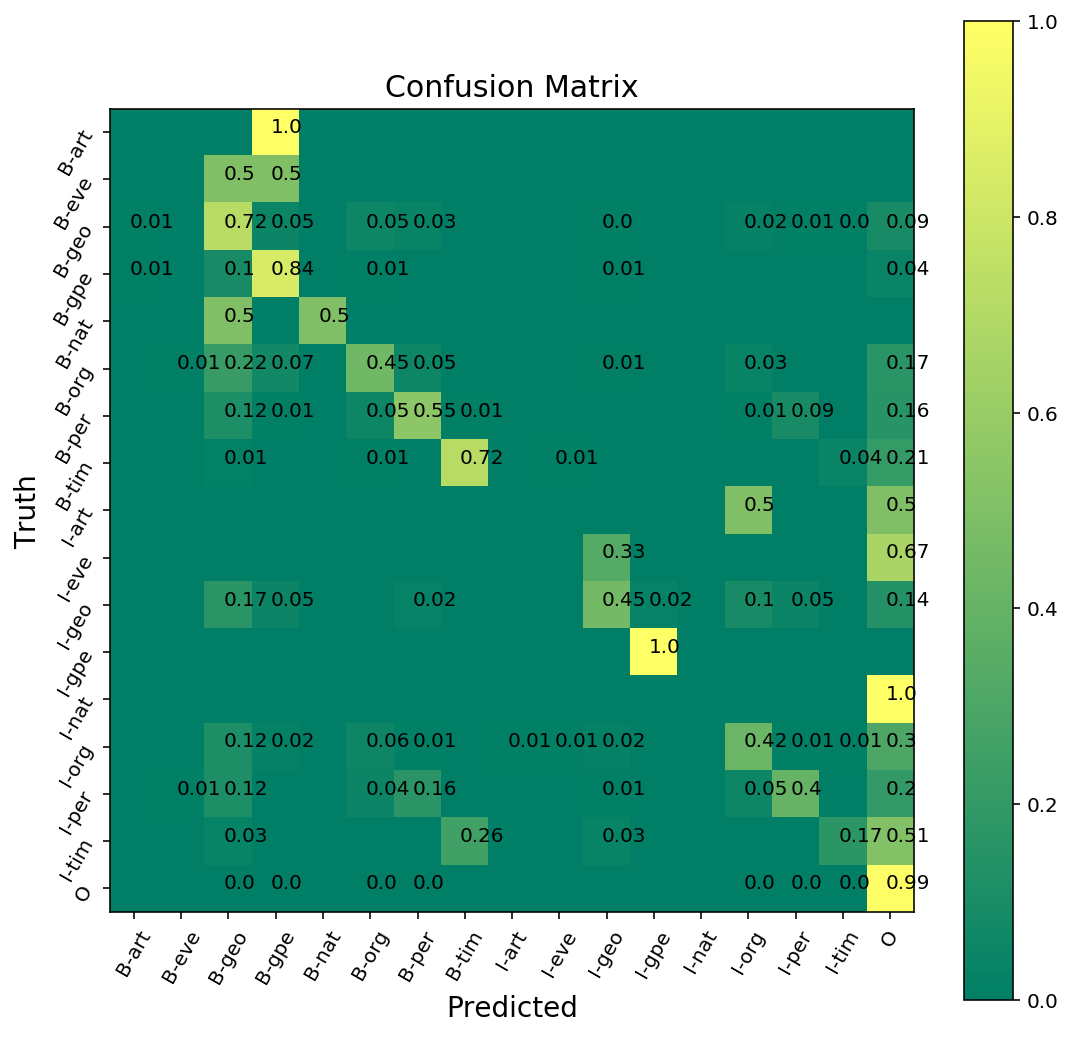

In [101]:
%config InlineBackend.figure_format = 'retina'
y_truth = df_testsplit['Tag']
labels=['B-art','B-eve','B-geo','B-gpe','B-nat','B-org','B-per','B-tim','I-art','I-eve','I-geo','I-gpe','I-nat','I-org','I-per','I-tim','O']
plot_confusion_matrix(truth=y_truth, predicted=ypred, labels = labels,save_name='multi-pred-cm')

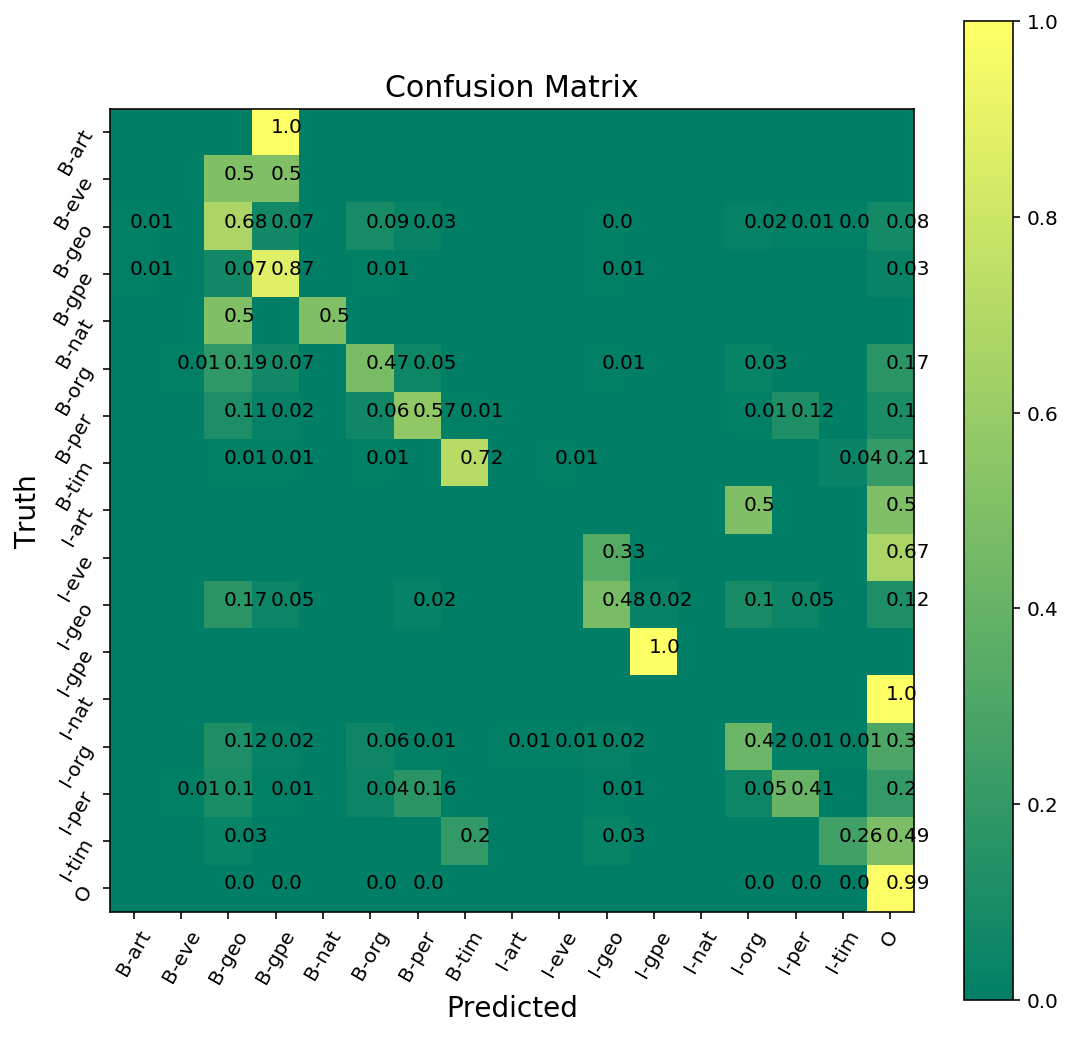

In [102]:
%config InlineBackend.figure_format = 'retina'

plot_confusion_matrix(truth=y_truth, predicted=ypred_clf, labels = labels,save_name='multi-clfpred-cm')

### Binary-class XGBoost classifier

In [103]:
CLASSES_DICT = {'B-art','B-eve','B-geo','B-gpe','B-nat','B-org','B-per','B-tim','I-art','I-eve','I-geo','I-gpe','I-nat','I-org','I-per','I-tim'}

In [105]:
# Binary classification with multiple XGBoost models

cl = []
for cl in CLASSES_DICT:
    df_current = deepcopy(df_trainsplit)
    df_current['Tag'] = df_current['Tag'].apply(lambda x: x if x  == cl else 'O')
    
    print ('Training model for class ->', cl)

    gbm_model,clf_model, tag_for_current_class = train_model(df_current[(df_current.split=='Train')|(df_current.split=='Validation')],features=xg_features)
    
    print ('Applying model for class ->', cl)
 
    pred_result = apply_model(xgb_model = gbm_model,cal_model = clf_model,df_test = df_testsplit,tag_class_dict=tag_for_current_class,features=xg_features)
    
    pred_result.to_csv('./result/pred_result_'+cl+'.csv')
    
    print ("Prediction Result saved to 'pred_result_",cl,".csv'")

Training model for class -> B-geo
[0]	validation_0-logloss:0.599567	validation_1-logloss:0.599633
[1]	validation_0-logloss:0.522915	validation_1-logloss:0.523058
[2]	validation_0-logloss:0.458956	validation_1-logloss:0.459185
[3]	validation_0-logloss:0.404771	validation_1-logloss:0.404986
[4]	validation_0-logloss:0.358657	validation_1-logloss:0.358897
[5]	validation_0-logloss:0.318937	validation_1-logloss:0.319284
[6]	validation_0-logloss:0.28441	validation_1-logloss:0.284849
[7]	validation_0-logloss:0.254557	validation_1-logloss:0.255071
[8]	validation_0-logloss:0.228313	validation_1-logloss:0.228883
[9]	validation_0-logloss:0.205084	validation_1-logloss:0.205705
[10]	validation_0-logloss:0.184595	validation_1-logloss:0.185339
[11]	validation_0-logloss:0.166415	validation_1-logloss:0.167211
[12]	validation_0-logloss:0.150325	validation_1-logloss:0.151231
[13]	validation_0-logloss:0.135972	validation_1-logloss:0.136955
[14]	validation_0-logloss:0.123183	validation_1-logloss:0.124211
[1

[25]	validation_0-logloss:0.04279	validation_1-logloss:0.044104
[26]	validation_0-logloss:0.03923	validation_1-logloss:0.040624
[27]	validation_0-logloss:0.036013	validation_1-logloss:0.037499
[28]	validation_0-logloss:0.033147	validation_1-logloss:0.034702
[29]	validation_0-logloss:0.030494	validation_1-logloss:0.032151
[30]	validation_0-logloss:0.028084	validation_1-logloss:0.029808
[31]	validation_0-logloss:0.025942	validation_1-logloss:0.027737
[32]	validation_0-logloss:0.02406	validation_1-logloss:0.025954
[33]	validation_0-logloss:0.022344	validation_1-logloss:0.024295
[34]	validation_0-logloss:0.020789	validation_1-logloss:0.022791
[35]	validation_0-logloss:0.019345	validation_1-logloss:0.021402
[36]	validation_0-logloss:0.018049	validation_1-logloss:0.020193
[37]	validation_0-logloss:0.016901	validation_1-logloss:0.019055
[38]	validation_0-logloss:0.015846	validation_1-logloss:0.018042
[39]	validation_0-logloss:0.014851	validation_1-logloss:0.017146
[40]	validation_0-logloss:0.

[50]	validation_0-logloss:0.003203	validation_1-logloss:0.003112
[51]	validation_0-logloss:0.00292	validation_1-logloss:0.002829
[52]	validation_0-logloss:0.002657	validation_1-logloss:0.002569
[53]	validation_0-logloss:0.002426	validation_1-logloss:0.002337
[54]	validation_0-logloss:0.00221	validation_1-logloss:0.002124
[55]	validation_0-logloss:0.002013	validation_1-logloss:0.001927
[56]	validation_0-logloss:0.001837	validation_1-logloss:0.001752
[57]	validation_0-logloss:0.001677	validation_1-logloss:0.001594
[58]	validation_0-logloss:0.001533	validation_1-logloss:0.001451
[59]	validation_0-logloss:0.0014	validation_1-logloss:0.001318
[60]	validation_0-logloss:0.001281	validation_1-logloss:0.001198
[61]	validation_0-logloss:0.001183	validation_1-logloss:0.001099
[62]	validation_0-logloss:0.001086	validation_1-logloss:0.001003
[63]	validation_0-logloss:0.001002	validation_1-logloss:0.000919
[64]	validation_0-logloss:0.000923	validation_1-logloss:0.00084
[65]	validation_0-logloss:0.00

[75]	validation_0-logloss:0.001771	validation_1-logloss:0.003036
[76]	validation_0-logloss:0.001726	validation_1-logloss:0.003009
[77]	validation_0-logloss:0.001683	validation_1-logloss:0.003018
[78]	validation_0-logloss:0.00164	validation_1-logloss:0.003009
[79]	validation_0-logloss:0.001592	validation_1-logloss:0.00297
[80]	validation_0-logloss:0.001546	validation_1-logloss:0.002952
[81]	validation_0-logloss:0.001488	validation_1-logloss:0.002923
[82]	validation_0-logloss:0.001438	validation_1-logloss:0.002892
[83]	validation_0-logloss:0.001402	validation_1-logloss:0.002874
[84]	validation_0-logloss:0.001374	validation_1-logloss:0.002852
[85]	validation_0-logloss:0.001337	validation_1-logloss:0.002856
[86]	validation_0-logloss:0.001299	validation_1-logloss:0.002849
[87]	validation_0-logloss:0.001275	validation_1-logloss:0.002852
[88]	validation_0-logloss:0.001246	validation_1-logloss:0.002847
[89]	validation_0-logloss:0.001217	validation_1-logloss:0.002864
[90]	validation_0-logloss:0

Applying model for class -> I-nat
Prediction Result saved to 'pred_result_ I-nat .csv'
Training model for class -> B-per
[0]	validation_0-logloss:0.598639	validation_1-logloss:0.598664
[1]	validation_0-logloss:0.521244	validation_1-logloss:0.521264
[2]	validation_0-logloss:0.456675	validation_1-logloss:0.456772
[3]	validation_0-logloss:0.402123	validation_1-logloss:0.402248
[4]	validation_0-logloss:0.355514	validation_1-logloss:0.355654
[5]	validation_0-logloss:0.315338	validation_1-logloss:0.315512
[6]	validation_0-logloss:0.280515	validation_1-logloss:0.280747
[7]	validation_0-logloss:0.250192	validation_1-logloss:0.250564
[8]	validation_0-logloss:0.223639	validation_1-logloss:0.224132
[9]	validation_0-logloss:0.200208	validation_1-logloss:0.200708
[10]	validation_0-logloss:0.17953	validation_1-logloss:0.180059
[11]	validation_0-logloss:0.161204	validation_1-logloss:0.16175
[12]	validation_0-logloss:0.14494	validation_1-logloss:0.145527
[13]	validation_0-logloss:0.130481	validation_1

[24]	validation_0-logloss:0.045985	validation_1-logloss:0.04812
[25]	validation_0-logloss:0.042092	validation_1-logloss:0.044335
[26]	validation_0-logloss:0.038601	validation_1-logloss:0.040942
[27]	validation_0-logloss:0.035482	validation_1-logloss:0.037895
[28]	validation_0-logloss:0.032669	validation_1-logloss:0.035178
[29]	validation_0-logloss:0.030108	validation_1-logloss:0.032708
[30]	validation_0-logloss:0.027799	validation_1-logloss:0.030492
[31]	validation_0-logloss:0.025731	validation_1-logloss:0.028505
[32]	validation_0-logloss:0.023883	validation_1-logloss:0.026748
[33]	validation_0-logloss:0.022199	validation_1-logloss:0.025142
[34]	validation_0-logloss:0.020691	validation_1-logloss:0.023721
[35]	validation_0-logloss:0.019312	validation_1-logloss:0.022466
[36]	validation_0-logloss:0.018086	validation_1-logloss:0.021315
[37]	validation_0-logloss:0.016968	validation_1-logloss:0.020292
[38]	validation_0-logloss:0.01593	validation_1-logloss:0.019316
[39]	validation_0-logloss:0

[49]	validation_0-logloss:0.003603	validation_1-logloss:0.003513
[50]	validation_0-logloss:0.003281	validation_1-logloss:0.003188
[51]	validation_0-logloss:0.002996	validation_1-logloss:0.002897
[52]	validation_0-logloss:0.002731	validation_1-logloss:0.002631
[53]	validation_0-logloss:0.002502	validation_1-logloss:0.002395
[54]	validation_0-logloss:0.002284	validation_1-logloss:0.002174
[55]	validation_0-logloss:0.002089	validation_1-logloss:0.001977
[56]	validation_0-logloss:0.001912	validation_1-logloss:0.001798
[57]	validation_0-logloss:0.001751	validation_1-logloss:0.001637
[58]	validation_0-logloss:0.001605	validation_1-logloss:0.001488
[59]	validation_0-logloss:0.001473	validation_1-logloss:0.001353
[60]	validation_0-logloss:0.001354	validation_1-logloss:0.001234
[61]	validation_0-logloss:0.001254	validation_1-logloss:0.001132
[62]	validation_0-logloss:0.001156	validation_1-logloss:0.001034
[63]	validation_0-logloss:0.001068	validation_1-logloss:0.000945
[64]	validation_0-logloss

[74]	validation_0-logloss:0.002668	validation_1-logloss:0.007854
[75]	validation_0-logloss:0.002609	validation_1-logloss:0.007829
[76]	validation_0-logloss:0.002552	validation_1-logloss:0.007817
[77]	validation_0-logloss:0.002496	validation_1-logloss:0.007799
[78]	validation_0-logloss:0.002433	validation_1-logloss:0.00777
[79]	validation_0-logloss:0.002384	validation_1-logloss:0.007737
[80]	validation_0-logloss:0.002349	validation_1-logloss:0.007721
[81]	validation_0-logloss:0.0023	validation_1-logloss:0.007729
[82]	validation_0-logloss:0.002255	validation_1-logloss:0.007701
[83]	validation_0-logloss:0.002217	validation_1-logloss:0.007696
[84]	validation_0-logloss:0.002164	validation_1-logloss:0.007711
[85]	validation_0-logloss:0.00214	validation_1-logloss:0.007691
[86]	validation_0-logloss:0.002091	validation_1-logloss:0.00766
[87]	validation_0-logloss:0.002058	validation_1-logloss:0.007649
[88]	validation_0-logloss:0.002009	validation_1-logloss:0.007593
[89]	validation_0-logloss:0.00

[99]	validation_0-logloss:0.000423	validation_1-logloss:0.000747
Applying model for class -> B-art
Prediction Result saved to 'pred_result_ B-art .csv'
Training model for class -> I-eve
[0]	validation_0-logloss:0.598346	validation_1-logloss:0.598388
[1]	validation_0-logloss:0.520706	validation_1-logloss:0.520787
[2]	validation_0-logloss:0.455969	validation_1-logloss:0.456087
[3]	validation_0-logloss:0.401248	validation_1-logloss:0.4014
[4]	validation_0-logloss:0.354512	validation_1-logloss:0.354696
[5]	validation_0-logloss:0.314258	validation_1-logloss:0.314472
[6]	validation_0-logloss:0.279319	validation_1-logloss:0.279584
[7]	validation_0-logloss:0.248847	validation_1-logloss:0.249165
[8]	validation_0-logloss:0.222144	validation_1-logloss:0.222509
[9]	validation_0-logloss:0.19867	validation_1-logloss:0.199064
[10]	validation_0-logloss:0.177966	validation_1-logloss:0.178387
[11]	validation_0-logloss:0.159636	validation_1-logloss:0.160084
[12]	validation_0-logloss:0.143357	validation_1

[22]	validation_0-logloss:0.051254	validation_1-logloss:0.0513
[23]	validation_0-logloss:0.046444	validation_1-logloss:0.046507
[24]	validation_0-logloss:0.042014	validation_1-logloss:0.042113
[25]	validation_0-logloss:0.037934	validation_1-logloss:0.038031
[26]	validation_0-logloss:0.034284	validation_1-logloss:0.034376
[27]	validation_0-logloss:0.031046	validation_1-logloss:0.031147
[28]	validation_0-logloss:0.028087	validation_1-logloss:0.028185
[29]	validation_0-logloss:0.025447	validation_1-logloss:0.025544
[30]	validation_0-logloss:0.023041	validation_1-logloss:0.023144
[31]	validation_0-logloss:0.020895	validation_1-logloss:0.021032
[32]	validation_0-logloss:0.019008	validation_1-logloss:0.019161
[33]	validation_0-logloss:0.01723	validation_1-logloss:0.017383
[34]	validation_0-logloss:0.015624	validation_1-logloss:0.015792
[35]	validation_0-logloss:0.014191	validation_1-logloss:0.014381
[36]	validation_0-logloss:0.012875	validation_1-logloss:0.013077
[37]	validation_0-logloss:0.

[47]	validation_0-logloss:0.007358	validation_1-logloss:0.010105
[48]	validation_0-logloss:0.006937	validation_1-logloss:0.009754
[49]	validation_0-logloss:0.006568	validation_1-logloss:0.00943
[50]	validation_0-logloss:0.006223	validation_1-logloss:0.00914
[51]	validation_0-logloss:0.00592	validation_1-logloss:0.008918
[52]	validation_0-logloss:0.005639	validation_1-logloss:0.008719
[53]	validation_0-logloss:0.005384	validation_1-logloss:0.008512
[54]	validation_0-logloss:0.005137	validation_1-logloss:0.00832
[55]	validation_0-logloss:0.004882	validation_1-logloss:0.008149
[56]	validation_0-logloss:0.004671	validation_1-logloss:0.007969
[57]	validation_0-logloss:0.004461	validation_1-logloss:0.007865
[58]	validation_0-logloss:0.004257	validation_1-logloss:0.007719
[59]	validation_0-logloss:0.004094	validation_1-logloss:0.007627
[60]	validation_0-logloss:0.00392	validation_1-logloss:0.00752
[61]	validation_0-logloss:0.003789	validation_1-logloss:0.007457
[62]	validation_0-logloss:0.003

[72]	validation_0-logloss:0.005882	validation_1-logloss:0.00978
[73]	validation_0-logloss:0.005801	validation_1-logloss:0.009732
[74]	validation_0-logloss:0.005698	validation_1-logloss:0.009695
[75]	validation_0-logloss:0.00563	validation_1-logloss:0.009664
[76]	validation_0-logloss:0.00557	validation_1-logloss:0.009638
[77]	validation_0-logloss:0.005442	validation_1-logloss:0.009607
[78]	validation_0-logloss:0.005391	validation_1-logloss:0.009578
[79]	validation_0-logloss:0.005264	validation_1-logloss:0.009486
[80]	validation_0-logloss:0.005151	validation_1-logloss:0.009492
[81]	validation_0-logloss:0.005	validation_1-logloss:0.009496
[82]	validation_0-logloss:0.004885	validation_1-logloss:0.009475
[83]	validation_0-logloss:0.004699	validation_1-logloss:0.009417
[84]	validation_0-logloss:0.004633	validation_1-logloss:0.009404
[85]	validation_0-logloss:0.004528	validation_1-logloss:0.009343
[86]	validation_0-logloss:0.004399	validation_1-logloss:0.00932
[87]	validation_0-logloss:0.0043

[97]	validation_0-logloss:0.004717	validation_1-logloss:0.013106
[98]	validation_0-logloss:0.004632	validation_1-logloss:0.013104
[99]	validation_0-logloss:0.004585	validation_1-logloss:0.013142
Applying model for class -> B-org
Prediction Result saved to 'pred_result_ B-org .csv'
Training model for class -> B-eve
[0]	validation_0-logloss:0.5982	validation_1-logloss:0.598181
[1]	validation_0-logloss:0.520441	validation_1-logloss:0.520418
[2]	validation_0-logloss:0.455586	validation_1-logloss:0.455547
[3]	validation_0-logloss:0.400764	validation_1-logloss:0.400711
[4]	validation_0-logloss:0.353938	validation_1-logloss:0.353874
[5]	validation_0-logloss:0.313598	validation_1-logloss:0.313529
[6]	validation_0-logloss:0.278606	validation_1-logloss:0.278531
[7]	validation_0-logloss:0.248098	validation_1-logloss:0.248033
[8]	validation_0-logloss:0.221369	validation_1-logloss:0.221319
[9]	validation_0-logloss:0.197837	validation_1-logloss:0.197777
[10]	validation_0-logloss:0.177065	validation_

In [106]:
df_testsplit.to_csv('./result/test_data.csv')

### SMOTE Oversampled sample

In [123]:
df_imbalance =deepcopy(df_for_bal)

In [144]:
train_set, test_set, train_idx, test_idx = train_test_split(df_imbalance, df_imbalance.index, test_size=0.1, random_state=42)
df_imbalance.ix[test_idx,'split'] = 'Test'
df_imbalance.ix[train_idx,'split'] = 'Train'

### Train/Test Split

In [145]:
# Training Data is imbalanced
df_imbalance_train = df_imbalance[df_imbalance.split=='Train']
print(df_imbalance_train["Tag"].value_counts())

# I try to use SMOTE to solve this problem

O        50596
B-geo     1869
B-org     1120
I-per     1119
B-gpe     1107
B-tim     1027
B-per      980
I-org      839
I-geo      376
I-tim      302
B-art       46
B-eve       40
I-eve       33
I-art       32
I-gpe       31
B-nat       19
I-nat        8
Name: Tag, dtype: int64


In [146]:
# Recreate the Sequence model features
features = []
corpus = create_corpus(df_imbalance_train['Word'].values, df_imbalance_train['Tag'].values)
s = create_corpus(df_imbalance_train['Word'].values, tag_list= None)
model_folder = './model/'

# Unigram model
unigram_tagger = nltk.UnigramTagger(corpus)
unigram_tag_list = unigram_tagger.tag_sents(s)
unigram_result = [x[1] for sl in unigram_tag_list for x in sl]
# Save model for testing data
# dill.dump(unigram_tagger, open(model_folder+"/"+'Unigram_model',"wb"))
# Add columns in df
df_imbalance_train['Unigram_model'] = unigram_result
features.append('Unigram_model')

# Bigram model
bigram_tagger = nltk.BigramTagger(corpus)
bigram_tag_list = bigram_tagger.tag_sents(s)
bigram_result = [x[1] for sl in bigram_tag_list for x in sl]
# dill.dump(bigram_tagger, open(model_folder+"/"+'Bigram_model',"wb"))
df_imbalance_train['Bigram_model'] = bigram_result
features.append('Bigram_model')


# Tigram model
trigram_tagger = nltk.TrigramTagger(corpus)
trigram_tag_list = trigram_tagger.tag_sents(s)
trigram_result = [x[1] for sl in trigram_tag_list for x in sl]
# dill.dump(trigram_tagger, open(model_folder+"/"+'Tigram_model',"wb"))
df_imbalance_train['Trigram_model'] = trigram_result
features.append('Trigram_model')

# Hidden Markov Model
trainer = hmm.HiddenMarkovModelTrainer()
HMM_tagger = trainer.train_supervised(corpus)
hmm_tag_list = HMM_tagger.tag_sents(s)
hmm_result = [x[1] for sl in hmm_tag_list for x in sl]
# dill.dump(HMM_tagger, open(model_folder+"/"+'HMM_model',"wb"))
df_imbalance_train['HMM_model'] = hmm_result
features.append('HMM_model')

# CRF Model
CRF_tagger = CRFTagger()
corpus1 = [[(str(sl[0]),sl[1]) for sl in s] for s in corpus]
CRF_tagger.train(corpus1, './model/'+'/'+'CRF')
crf_tag_list = CRF_tagger.tag_sents(s)
crf_result = [x[1] for sl in crf_tag_list for x in sl]
# dill.dump(CRF_tagger, open(model_folder+"/"+'CRF',"wb"))
df_imbalance_train['CRF'] = crf_result
features.append('CRF')


# Perceptron Model
Percep_tagger = PerceptronTagger(load=False)
Percep_tagger.train(corpus)
per_tag_list = Percep_tagger.tag_sents(s)
Percep_result = [x[1] for sl in per_tag_list for x in sl]
# dill.dump(Percep_tagger, open(model_folder+"/"+'Perceptron',"wb"))
df_imbalance_train['Perceptron'] = Percep_result
features.append('Perceptron')

# Affix Model
Affix_tagger = nltk.AffixTagger(train=corpus)
Affix_tag_list = Affix_tagger.tag_sents(s)
Affix_result = [x[1] for sl in Affix_tag_list for x in sl]
# dill.dump(Affix_tagger, open(model_folder+"/"+'Affix',"wb"))
df_imbalance_train['Affix'] = Affix_result
features.append('Affix')

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [147]:
for f in features:
    # convert to numeric
    f_num = f + '_num'
    df_imbalance_train[f_num] = df_imbalance_train[f].apply(lambda x: tag_class_dict[x] if x in tag_class_dict else -1)
    xg_ft_before_sq.append(f_num)
    for k in range(0,5):
        # PoS features
        df_imbalance_train[f_num+str(k)] = ie.add_next_feat_num(df_imbalance_train[f_num],k+1)
        # add word dict features
        xg_ft_before_sq.append(f_num+str(k))
        
## Sequence model trained

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [170]:
df_imbalance_test = df_imbalance[df_imbalance.split=='Test']

In [172]:
### SMOTE Testing data sequence model
features = []
s = create_corpus(df_imbalance_test['Word'].values, tag_list= None)

# Unigram model
unigram_tag_list = unigram_tagger.tag_sents(s)
unigram_result = [x[1] for sl in unigram_tag_list for x in sl]
# Add columns in df_testing
df_imbalance_test['Unigram_model'] = unigram_result
features.append('Unigram_model')


# Bigram model
bigram_tag_list = bigram_tagger.tag_sents(s)
bigram_result = [x[1] for sl in bigram_tag_list for x in sl]
df_imbalance_test['Bigram_model'] = bigram_result
features.append('Bigram_model')


# Tigram model
trigram_tag_list = trigram_tagger.tag_sents(s)
trigram_result = [x[1] for sl in trigram_tag_list for x in sl]
df_imbalance_test['Trigram_model'] = trigram_result
features.append('Trigram_model')

# Hidden Markov Model
hmm_tag_list = HMM_tagger.tag_sents(s)
hmm_result = [x[1] for sl in hmm_tag_list for x in sl]
df_imbalance_test['HMM_model'] = hmm_result
features.append('HMM_model')

# CRF Model
crf_tag_list = CRF_tagger.tag_sents(s)
crf_result = [x[1] for sl in crf_tag_list for x in sl]
df_imbalance_test['CRF'] = crf_result
features.append('CRF')


# Perceptron Model
per_tag_list = Percep_tagger.tag_sents(s)
Percep_result = [x[1] for sl in per_tag_list for x in sl]
df_imbalance_test['Perceptron'] = Percep_result
features.append('Perceptron')

# Affix Model
Affix_tag_list = Affix_tagger.tag_sents(s)
Affix_result = [x[1] for sl in Affix_tag_list for x in sl]
df_imbalance_test['Affix'] = Affix_result
features.append('Affix')

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [173]:
for f in features:
    # convert to numeric
    f_num = f + '_num'
    df_imbalance_test[f_num] = df_imbalance_test[f].apply(lambda x: tag_class_dict[x] if x in tag_class_dict else -1)
    for k in range(0,5):
        # PoS features
        df_imbalance_test[f_num+str(k)] = ie.add_next_feat_num(df_imbalance_test[f_num],k+1)

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### Create the SMOTE sample

In [ ]:
xg_smote_ft = deepcopy(xg_ft_before_sq)

Y = df_imbalance_train["Tag"]
X = df_imbalance_train[xg_smote_ft]

In [157]:
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_sample(X, Y)
df_bal = pd.DataFrame(X_res)
df_bal.columns = X.columns
df_bal["Tag"] = Y_res

In [158]:
import random

random.seed(2018)
df_bal_sample = df_bal.sample(150000)

In [159]:
# Train, validation split
train_set, val_set, train_idx, val_idx = train_test_split(df_bal_sample, df_bal_sample.index, test_size=0.25, random_state=42)

df_bal_sample.ix[train_idx,'split'] = 'Train'
df_bal_sample.ix[val_idx,'split'] = 'Validation'

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


### Multi-class XGBoost Classifier

In [162]:
df_current = deepcopy(df_bal_sample)
X_train = df_current[df_current.split=='Train']
X_val  = df_current[df_current.split=='Validation']

n_estimators = 100

eval_set = [(X_train[xg_smote_ft].values,X_train['Tag']),(X_val[xg_smote_ft].values,X_val['Tag'])]

xgb_model = xgb.XGBClassifier(learning_rate =0.1,n_estimators=n_estimators, silent=True,
                                max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                               colsample_bytree=0.8,
                               objective= 'multi:softmax',seed=27, missing=np.nan)

gbm = xgb_model.fit(X_train[xg_smote_ft].values, X_train['Tag'].values, eval_metric="mlogloss", eval_set=eval_set, verbose=True)
    
from sklearn.calibration import CalibratedClassifierCV

clf_isotonic = CalibratedClassifierCV(gbm, cv='prefit', method='isotonic')
clf_isotonic.fit(X_val[xg_smote_ft].values, X_val["Tag"])

[0]	validation_0-mlogloss:2.13567	validation_1-mlogloss:2.13705
[1]	validation_0-mlogloss:1.78492	validation_1-mlogloss:1.7866
[2]	validation_0-mlogloss:1.53616	validation_1-mlogloss:1.53955
[3]	validation_0-mlogloss:1.34763	validation_1-mlogloss:1.35218
[4]	validation_0-mlogloss:1.19686	validation_1-mlogloss:1.20194
[5]	validation_0-mlogloss:1.07186	validation_1-mlogloss:1.07771
[6]	validation_0-mlogloss:0.963342	validation_1-mlogloss:0.969728
[7]	validation_0-mlogloss:0.871148	validation_1-mlogloss:0.878004
[8]	validation_0-mlogloss:0.789492	validation_1-mlogloss:0.796956
[9]	validation_0-mlogloss:0.718712	validation_1-mlogloss:0.726719
[10]	validation_0-mlogloss:0.655162	validation_1-mlogloss:0.663561
[11]	validation_0-mlogloss:0.598677	validation_1-mlogloss:0.60748
[12]	validation_0-mlogloss:0.548923	validation_1-mlogloss:0.558002
[13]	validation_0-mlogloss:0.503805	validation_1-mlogloss:0.513261
[14]	validation_0-mlogloss:0.463286	validation_1-mlogloss:0.473004
[15]	validation_0-m

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
            cv='prefit', method='isotonic')

In [175]:
df_test = df_imbalance_test
ypred = gbm.predict(df_test[xg_smote_ft].values)
ypred_clf = clf_isotonic.predict(df_test[xg_smote_ft].values)

### Multi-class confusion matrix

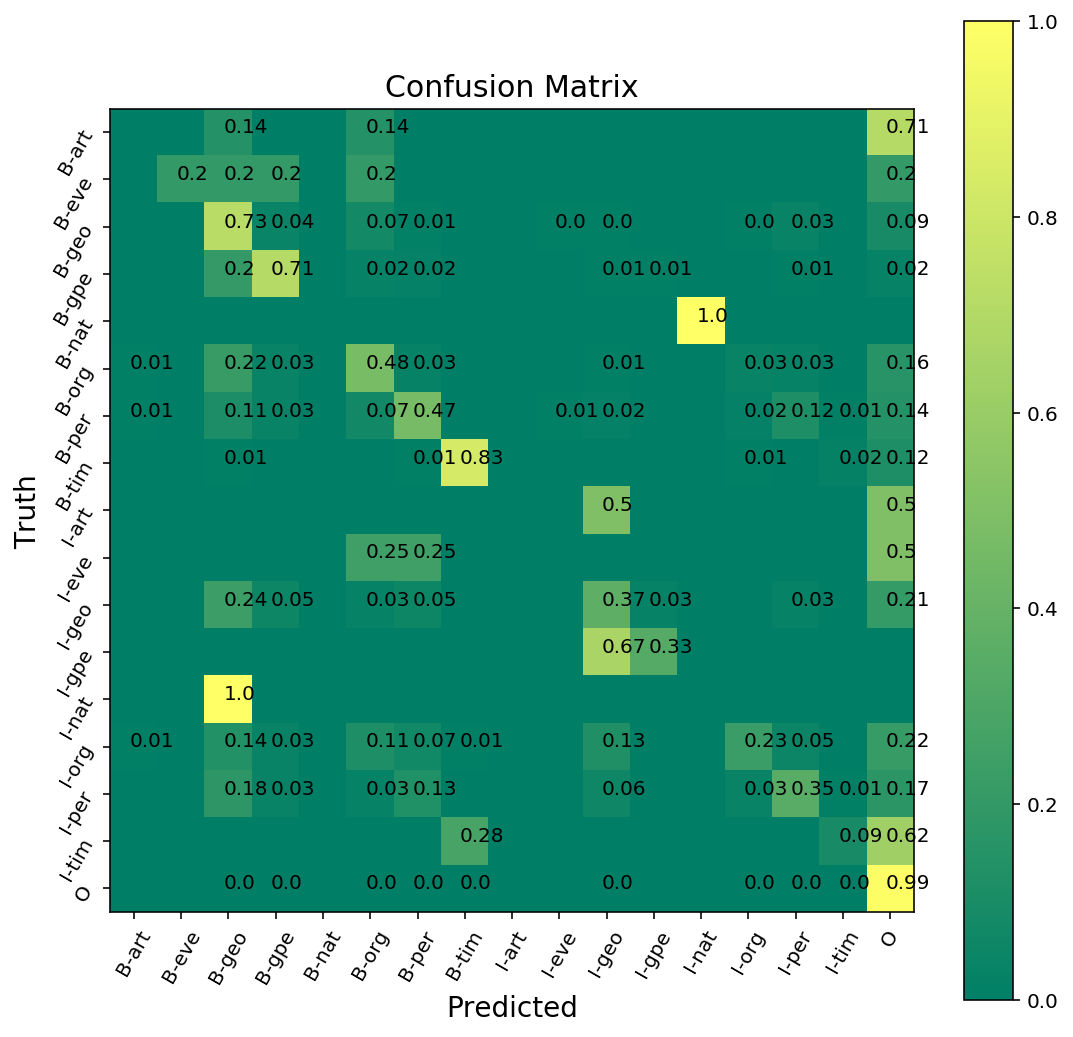

In [176]:
y_truth = df_test['Tag']
labels=['B-art','B-eve','B-geo','B-gpe','B-nat','B-org','B-per','B-tim','I-art','I-eve','I-geo','I-gpe','I-nat','I-org','I-per','I-tim','O']
%config InlineBackend.figure_format = 'retina'


plot_confusion_matrix(truth=y_truth, predicted=ypred, labels = labels,save_name='SMOTE-confusionmatrix1')

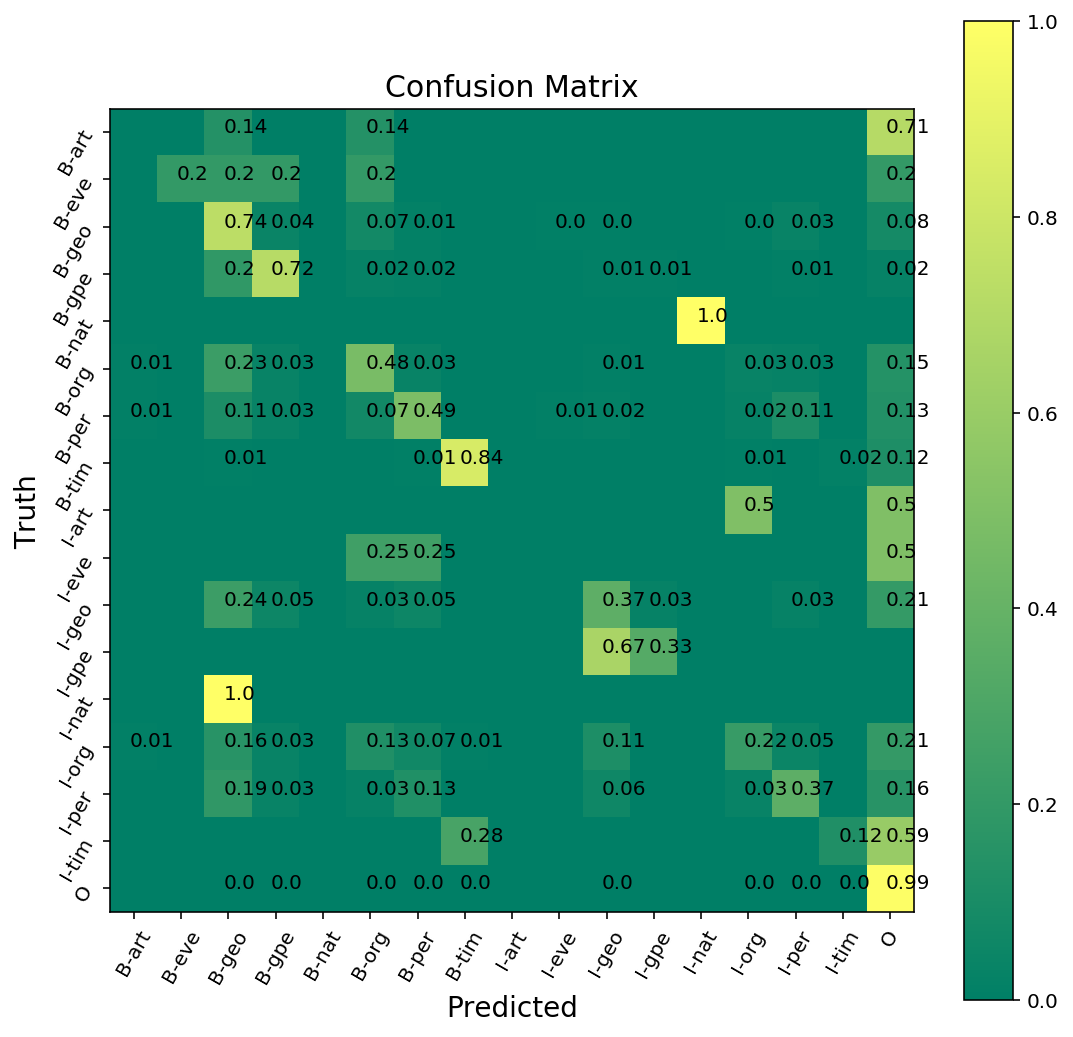

In [177]:
%config InlineBackend.figure_format = 'retina'

plot_confusion_matrix(truth=y_truth, predicted=ypred_clf, labels = labels,save_name='SMOTE-confusionmatrix2')

### Binary-class XGBoost classifier

In [32]:
CLASSES_DICT = {'B-art','B-eve','B-geo','B-gpe','B-nat','B-org','B-per','B-tim','I-art','I-eve','I-geo','I-gpe','I-nat','I-org','I-per','I-tim'}

In [178]:
cl = []
for cl in CLASSES_DICT:
    df_current = deepcopy(df_bal_sample)
    df_current['Tag'] = df_bal_sample['Tag'].apply(lambda x: x if x  == cl else 'O')
    
    print ('Training model for class ->', cl)

    gbm_model,clf_model, tag_for_current_class = train_model(df_current[(df_current.split=='Train')|(df_current.split=='Validation')],features=xg_smote_ft)
    
    print ('Applying model for class ->', cl)
 
    pred_result = apply_model(xgb_model = gbm_model,cal_model = clf_model,df_test = df_imbalance_test
                              ,tag_class_dict=tag_for_current_class,features = xg_smote_ft)
    
    pred_result.to_csv('./balance_model/pred_result_'+cl+'.csv')
    
    print ("Prediction Result saved to 'pred_result_",cl,".csv'")

Training model for class -> B-geo
[0]	validation_0-logloss:0.59971	validation_1-logloss:0.599633
[1]	validation_0-logloss:0.524769	validation_1-logloss:0.524754
[2]	validation_0-logloss:0.460653	validation_1-logloss:0.460643
[3]	validation_0-logloss:0.406447	validation_1-logloss:0.406434
[4]	validation_0-logloss:0.36017	validation_1-logloss:0.360165
[5]	validation_0-logloss:0.321368	validation_1-logloss:0.32138
[6]	validation_0-logloss:0.286639	validation_1-logloss:0.286657
[7]	validation_0-logloss:0.256403	validation_1-logloss:0.256439
[8]	validation_0-logloss:0.229909	validation_1-logloss:0.22995
[9]	validation_0-logloss:0.20663	validation_1-logloss:0.206677
[10]	validation_0-logloss:0.186728	validation_1-logloss:0.186782
[11]	validation_0-logloss:0.168466	validation_1-logloss:0.168504
[12]	validation_0-logloss:0.152315	validation_1-logloss:0.152381
[13]	validation_0-logloss:0.137911	validation_1-logloss:0.137954
[14]	validation_0-logloss:0.125101	validation_1-logloss:0.125125
[15]	v

[25]	validation_0-logloss:0.048541	validation_1-logloss:0.05014
[26]	validation_0-logloss:0.044891	validation_1-logloss:0.046582
[27]	validation_0-logloss:0.041576	validation_1-logloss:0.043327
[28]	validation_0-logloss:0.038633	validation_1-logloss:0.040426
[29]	validation_0-logloss:0.0359	validation_1-logloss:0.037748
[30]	validation_0-logloss:0.033288	validation_1-logloss:0.035274
[31]	validation_0-logloss:0.03105	validation_1-logloss:0.033123
[32]	validation_0-logloss:0.029002	validation_1-logloss:0.031118
[33]	validation_0-logloss:0.027105	validation_1-logloss:0.029282
[34]	validation_0-logloss:0.02541	validation_1-logloss:0.027673
[35]	validation_0-logloss:0.023879	validation_1-logloss:0.026218
[36]	validation_0-logloss:0.022435	validation_1-logloss:0.024868
[37]	validation_0-logloss:0.021165	validation_1-logloss:0.023644
[38]	validation_0-logloss:0.019996	validation_1-logloss:0.02257
[39]	validation_0-logloss:0.019013	validation_1-logloss:0.021617
[40]	validation_0-logloss:0.018

[50]	validation_0-logloss:0.003308	validation_1-logloss:0.003351
[51]	validation_0-logloss:0.003002	validation_1-logloss:0.003047
[52]	validation_0-logloss:0.002724	validation_1-logloss:0.002765
[53]	validation_0-logloss:0.002485	validation_1-logloss:0.002527
[54]	validation_0-logloss:0.002269	validation_1-logloss:0.002309
[55]	validation_0-logloss:0.002062	validation_1-logloss:0.002103
[56]	validation_0-logloss:0.001875	validation_1-logloss:0.001918
[57]	validation_0-logloss:0.001706	validation_1-logloss:0.00175
[58]	validation_0-logloss:0.001553	validation_1-logloss:0.001599
[59]	validation_0-logloss:0.001413	validation_1-logloss:0.001461
[60]	validation_0-logloss:0.001286	validation_1-logloss:0.001331
[61]	validation_0-logloss:0.001171	validation_1-logloss:0.001213
[62]	validation_0-logloss:0.001069	validation_1-logloss:0.001109
[63]	validation_0-logloss:0.000984	validation_1-logloss:0.001023
[64]	validation_0-logloss:0.000898	validation_1-logloss:0.000933
[65]	validation_0-logloss:

[75]	validation_0-logloss:0.001741	validation_1-logloss:0.003051
[76]	validation_0-logloss:0.00167	validation_1-logloss:0.003006
[77]	validation_0-logloss:0.001603	validation_1-logloss:0.002926
[78]	validation_0-logloss:0.001546	validation_1-logloss:0.002891
[79]	validation_0-logloss:0.001497	validation_1-logloss:0.002854
[80]	validation_0-logloss:0.001454	validation_1-logloss:0.002812
[81]	validation_0-logloss:0.001399	validation_1-logloss:0.002767
[82]	validation_0-logloss:0.001349	validation_1-logloss:0.002711
[83]	validation_0-logloss:0.001284	validation_1-logloss:0.002639
[84]	validation_0-logloss:0.001246	validation_1-logloss:0.002604
[85]	validation_0-logloss:0.001206	validation_1-logloss:0.00256
[86]	validation_0-logloss:0.001155	validation_1-logloss:0.002493
[87]	validation_0-logloss:0.001123	validation_1-logloss:0.002455
[88]	validation_0-logloss:0.001087	validation_1-logloss:0.002419
[89]	validation_0-logloss:0.001052	validation_1-logloss:0.002388
[90]	validation_0-logloss:0

Applying model for class -> I-nat
Prediction Result saved to 'pred_result_ I-nat .csv'
Training model for class -> B-per
[0]	validation_0-logloss:0.598975	validation_1-logloss:0.599031
[1]	validation_0-logloss:0.522833	validation_1-logloss:0.522924
[2]	validation_0-logloss:0.458276	validation_1-logloss:0.458416
[3]	validation_0-logloss:0.403757	validation_1-logloss:0.403942
[4]	validation_0-logloss:0.357188	validation_1-logloss:0.357423
[5]	validation_0-logloss:0.317581	validation_1-logloss:0.317854
[6]	validation_0-logloss:0.282727	validation_1-logloss:0.283052
[7]	validation_0-logloss:0.252296	validation_1-logloss:0.252685
[8]	validation_0-logloss:0.22567	validation_1-logloss:0.22612
[9]	validation_0-logloss:0.202259	validation_1-logloss:0.202745
[10]	validation_0-logloss:0.181879	validation_1-logloss:0.18241
[11]	validation_0-logloss:0.163543	validation_1-logloss:0.164152
[12]	validation_0-logloss:0.147299	validation_1-logloss:0.147971
[13]	validation_0-logloss:0.132827	validation_1

[24]	validation_0-logloss:0.05826	validation_1-logloss:0.059463
[25]	validation_0-logloss:0.054133	validation_1-logloss:0.05534
[26]	validation_0-logloss:0.050403	validation_1-logloss:0.051619
[27]	validation_0-logloss:0.04694	validation_1-logloss:0.048237
[28]	validation_0-logloss:0.043933	validation_1-logloss:0.045281
[29]	validation_0-logloss:0.041073	validation_1-logloss:0.042422
[30]	validation_0-logloss:0.038435	validation_1-logloss:0.039796
[31]	validation_0-logloss:0.036012	validation_1-logloss:0.03742
[32]	validation_0-logloss:0.033865	validation_1-logloss:0.035328
[33]	validation_0-logloss:0.031842	validation_1-logloss:0.03339
[34]	validation_0-logloss:0.030005	validation_1-logloss:0.031598
[35]	validation_0-logloss:0.02835	validation_1-logloss:0.02996
[36]	validation_0-logloss:0.026806	validation_1-logloss:0.028441
[37]	validation_0-logloss:0.025387	validation_1-logloss:0.027032
[38]	validation_0-logloss:0.024133	validation_1-logloss:0.025831
[39]	validation_0-logloss:0.0229

[49]	validation_0-logloss:0.005558	validation_1-logloss:0.005698
[50]	validation_0-logloss:0.005123	validation_1-logloss:0.005266
[51]	validation_0-logloss:0.004755	validation_1-logloss:0.004904
[52]	validation_0-logloss:0.004337	validation_1-logloss:0.004491
[53]	validation_0-logloss:0.004012	validation_1-logloss:0.004166
[54]	validation_0-logloss:0.003701	validation_1-logloss:0.003855
[55]	validation_0-logloss:0.003421	validation_1-logloss:0.003573
[56]	validation_0-logloss:0.003156	validation_1-logloss:0.003309
[57]	validation_0-logloss:0.002909	validation_1-logloss:0.003066
[58]	validation_0-logloss:0.002729	validation_1-logloss:0.002893
[59]	validation_0-logloss:0.002511	validation_1-logloss:0.002678
[60]	validation_0-logloss:0.002328	validation_1-logloss:0.002496
[61]	validation_0-logloss:0.002172	validation_1-logloss:0.002341
[62]	validation_0-logloss:0.002008	validation_1-logloss:0.002179
[63]	validation_0-logloss:0.001868	validation_1-logloss:0.002037
[64]	validation_0-logloss

[74]	validation_0-logloss:0.004887	validation_1-logloss:0.006312
[75]	validation_0-logloss:0.004811	validation_1-logloss:0.006253
[76]	validation_0-logloss:0.00468	validation_1-logloss:0.006132
[77]	validation_0-logloss:0.004606	validation_1-logloss:0.006071
[78]	validation_0-logloss:0.004494	validation_1-logloss:0.005967
[79]	validation_0-logloss:0.00438	validation_1-logloss:0.00587
[80]	validation_0-logloss:0.004314	validation_1-logloss:0.005826
[81]	validation_0-logloss:0.00424	validation_1-logloss:0.005755
[82]	validation_0-logloss:0.004175	validation_1-logloss:0.005687
[83]	validation_0-logloss:0.00411	validation_1-logloss:0.005619
[84]	validation_0-logloss:0.004028	validation_1-logloss:0.005533
[85]	validation_0-logloss:0.003963	validation_1-logloss:0.005475
[86]	validation_0-logloss:0.003914	validation_1-logloss:0.005434
[87]	validation_0-logloss:0.003848	validation_1-logloss:0.005363
[88]	validation_0-logloss:0.003743	validation_1-logloss:0.005305
[89]	validation_0-logloss:0.00

[99]	validation_0-logloss:0.00027	validation_1-logloss:0.000666
Applying model for class -> B-art
Prediction Result saved to 'pred_result_ B-art .csv'
Training model for class -> I-eve
[0]	validation_0-logloss:0.602992	validation_1-logloss:0.602965
[1]	validation_0-logloss:0.528917	validation_1-logloss:0.528817
[2]	validation_0-logloss:0.468425	validation_1-logloss:0.468214
[3]	validation_0-logloss:0.416272	validation_1-logloss:0.415943
[4]	validation_0-logloss:0.367532	validation_1-logloss:0.367223
[5]	validation_0-logloss:0.325581	validation_1-logloss:0.325369
[6]	validation_0-logloss:0.289381	validation_1-logloss:0.289183
[7]	validation_0-logloss:0.257786	validation_1-logloss:0.25759
[8]	validation_0-logloss:0.230161	validation_1-logloss:0.22997
[9]	validation_0-logloss:0.205747	validation_1-logloss:0.205588
[10]	validation_0-logloss:0.184334	validation_1-logloss:0.184185
[11]	validation_0-logloss:0.165571	validation_1-logloss:0.165485
[12]	validation_0-logloss:0.150073	validation_1

[23]	validation_0-logloss:0.058037	validation_1-logloss:0.058585
[24]	validation_0-logloss:0.053464	validation_1-logloss:0.054031
[25]	validation_0-logloss:0.049027	validation_1-logloss:0.049585
[26]	validation_0-logloss:0.045009	validation_1-logloss:0.04557
[27]	validation_0-logloss:0.041365	validation_1-logloss:0.041944
[28]	validation_0-logloss:0.03807	validation_1-logloss:0.038637
[29]	validation_0-logloss:0.035244	validation_1-logloss:0.035844
[30]	validation_0-logloss:0.032523	validation_1-logloss:0.033127
[31]	validation_0-logloss:0.030083	validation_1-logloss:0.030696
[32]	validation_0-logloss:0.027819	validation_1-logloss:0.028422
[33]	validation_0-logloss:0.025777	validation_1-logloss:0.026381
[34]	validation_0-logloss:0.023888	validation_1-logloss:0.024493
[35]	validation_0-logloss:0.022201	validation_1-logloss:0.022799
[36]	validation_0-logloss:0.020661	validation_1-logloss:0.021257
[37]	validation_0-logloss:0.019141	validation_1-logloss:0.019732
[38]	validation_0-logloss:0

[48]	validation_0-logloss:0.02307	validation_1-logloss:0.026681
[49]	validation_0-logloss:0.022478	validation_1-logloss:0.026143
[50]	validation_0-logloss:0.022023	validation_1-logloss:0.02568
[51]	validation_0-logloss:0.021581	validation_1-logloss:0.025243
[52]	validation_0-logloss:0.021143	validation_1-logloss:0.024791
[53]	validation_0-logloss:0.020604	validation_1-logloss:0.024339
[54]	validation_0-logloss:0.020096	validation_1-logloss:0.02383
[55]	validation_0-logloss:0.019576	validation_1-logloss:0.023401
[56]	validation_0-logloss:0.01913	validation_1-logloss:0.023006
[57]	validation_0-logloss:0.018286	validation_1-logloss:0.022202
[58]	validation_0-logloss:0.017984	validation_1-logloss:0.021924
[59]	validation_0-logloss:0.017691	validation_1-logloss:0.021618
[60]	validation_0-logloss:0.017284	validation_1-logloss:0.021182
[61]	validation_0-logloss:0.017026	validation_1-logloss:0.020911
[62]	validation_0-logloss:0.016336	validation_1-logloss:0.020199
[63]	validation_0-logloss:0.0

[73]	validation_0-logloss:0.007679	validation_1-logloss:0.00933
[74]	validation_0-logloss:0.007561	validation_1-logloss:0.009215
[75]	validation_0-logloss:0.007368	validation_1-logloss:0.009012
[76]	validation_0-logloss:0.007212	validation_1-logloss:0.00885
[77]	validation_0-logloss:0.007131	validation_1-logloss:0.008772
[78]	validation_0-logloss:0.007029	validation_1-logloss:0.008666
[79]	validation_0-logloss:0.006829	validation_1-logloss:0.008452
[80]	validation_0-logloss:0.006709	validation_1-logloss:0.008347
[81]	validation_0-logloss:0.006634	validation_1-logloss:0.008284
[82]	validation_0-logloss:0.006545	validation_1-logloss:0.008194
[83]	validation_0-logloss:0.006431	validation_1-logloss:0.008095
[84]	validation_0-logloss:0.006223	validation_1-logloss:0.007884
[85]	validation_0-logloss:0.006096	validation_1-logloss:0.007762
[86]	validation_0-logloss:0.006011	validation_1-logloss:0.007678
[87]	validation_0-logloss:0.005828	validation_1-logloss:0.007499
[88]	validation_0-logloss:0

[98]	validation_0-logloss:0.011188	validation_1-logloss:0.016088
[99]	validation_0-logloss:0.01101	validation_1-logloss:0.015931
Applying model for class -> B-org
Prediction Result saved to 'pred_result_ B-org .csv'
Training model for class -> B-eve
[0]	validation_0-logloss:0.598185	validation_1-logloss:0.598195
[1]	validation_0-logloss:0.521832	validation_1-logloss:0.52179
[2]	validation_0-logloss:0.456727	validation_1-logloss:0.45669
[3]	validation_0-logloss:0.401711	validation_1-logloss:0.401682
[4]	validation_0-logloss:0.354715	validation_1-logloss:0.354692
[5]	validation_0-logloss:0.315213	validation_1-logloss:0.315181
[6]	validation_0-logloss:0.279981	validation_1-logloss:0.279953
[7]	validation_0-logloss:0.249259	validation_1-logloss:0.249234
[8]	validation_0-logloss:0.222344	validation_1-logloss:0.222323
[9]	validation_0-logloss:0.198667	validation_1-logloss:0.19865
[10]	validation_0-logloss:0.178277	validation_1-logloss:0.178274
[11]	validation_0-logloss:0.159721	validation_1-

In [179]:
df_test = df_imbalance_test
df_test.to_csv("./balance_model/df_bal_test.csv")

### Combined Original Sample

In [197]:
### Combined data

df_com = pd.read_csv('df_combine.csv', encoding='Windows-1252')
df_com = df_com.drop(df_com.columns[[0]], axis=1)

In [199]:
print(df_com["split"].value_counts())

Train         43004
Validation    16541
Test           6616
Name: split, dtype: int64


### Train/Test Spilit

### Multi-class XGBoost classifier

In [201]:
df_current = deepcopy(df_com)
X_train = df_current[df_current.split=='Train']
X_val  = df_current[df_current.split=='Validation']

n_estimators = 100

eval_set = [(X_train[xg_features].values,X_train['Tag']),(X_val[xg_features].values,X_val['Tag'])]

xgb_model = xgb.XGBClassifier(learning_rate =0.1,n_estimators=n_estimators, silent=True,
                                max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                               colsample_bytree=0.8,
                               objective= 'multi:softmax',seed=27, missing=np.nan)

gbm = xgb_model.fit(X_train[xg_features].values, X_train['Tag'].values, eval_metric="mlogloss", eval_set=eval_set, verbose=True)
    
from sklearn.calibration import CalibratedClassifierCV

clf_isotonic = CalibratedClassifierCV(gbm, cv='prefit', method='isotonic')
clf_isotonic.fit(X_val[xg_features].values, X_val["Tag"])

[0]	validation_0-mlogloss:1.77472	validation_1-mlogloss:1.77617
[1]	validation_0-mlogloss:1.50176	validation_1-mlogloss:1.5039
[2]	validation_0-mlogloss:1.30001	validation_1-mlogloss:1.30306
[3]	validation_0-mlogloss:1.13971	validation_1-mlogloss:1.14338
[4]	validation_0-mlogloss:1.00787	validation_1-mlogloss:1.01222
[5]	validation_0-mlogloss:0.897499	validation_1-mlogloss:0.902638
[6]	validation_0-mlogloss:0.802052	validation_1-mlogloss:0.807773
[7]	validation_0-mlogloss:0.719654	validation_1-mlogloss:0.725894
[8]	validation_0-mlogloss:0.647614	validation_1-mlogloss:0.654317
[9]	validation_0-mlogloss:0.58424	validation_1-mlogloss:0.591423
[10]	validation_0-mlogloss:0.528416	validation_1-mlogloss:0.536051
[11]	validation_0-mlogloss:0.47858	validation_1-mlogloss:0.486662
[12]	validation_0-mlogloss:0.434488	validation_1-mlogloss:0.443039
[13]	validation_0-mlogloss:0.394901	validation_1-mlogloss:0.403873
[14]	validation_0-mlogloss:0.359666	validation_1-mlogloss:0.369104
[15]	validation_0-

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
            cv='prefit', method='isotonic')

In [202]:
df_test = df_current[(df_current.split=='Test')]
ypred = gbm.predict(df_test[xg_features].values)
ypred_clf = clf_isotonic.predict(df_test[xg_features].values)

In [208]:
df_test.to_csv("./combined/df_com_test.csv")

### Multi-class Confusion Matirx

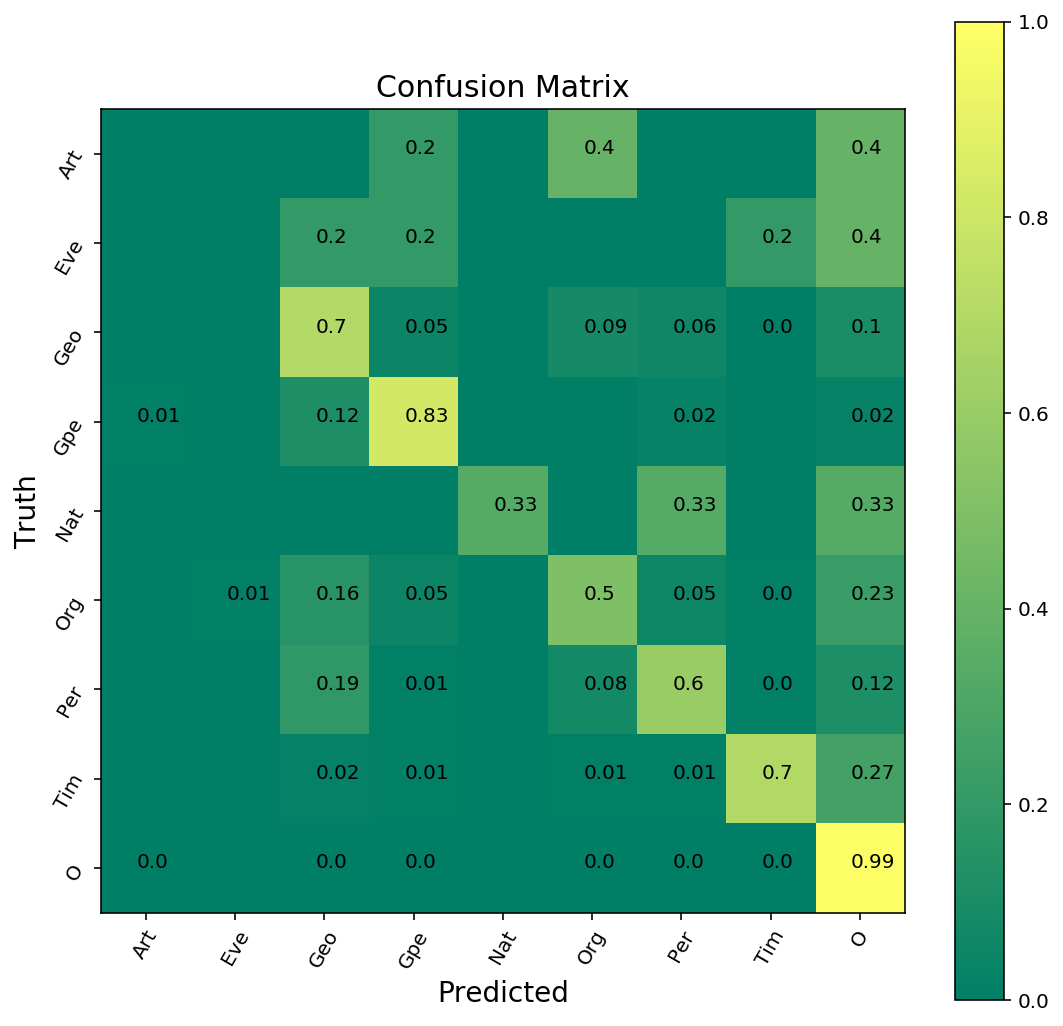

In [205]:
y_truth = df_test['Tag']
labels=['Art','Eve','Geo','Gpe','Nat','Org','Per','Tim','O']
plot_confusion_matrix(truth=y_truth, predicted=ypred, labels = labels,save_name='df_com_cm1')

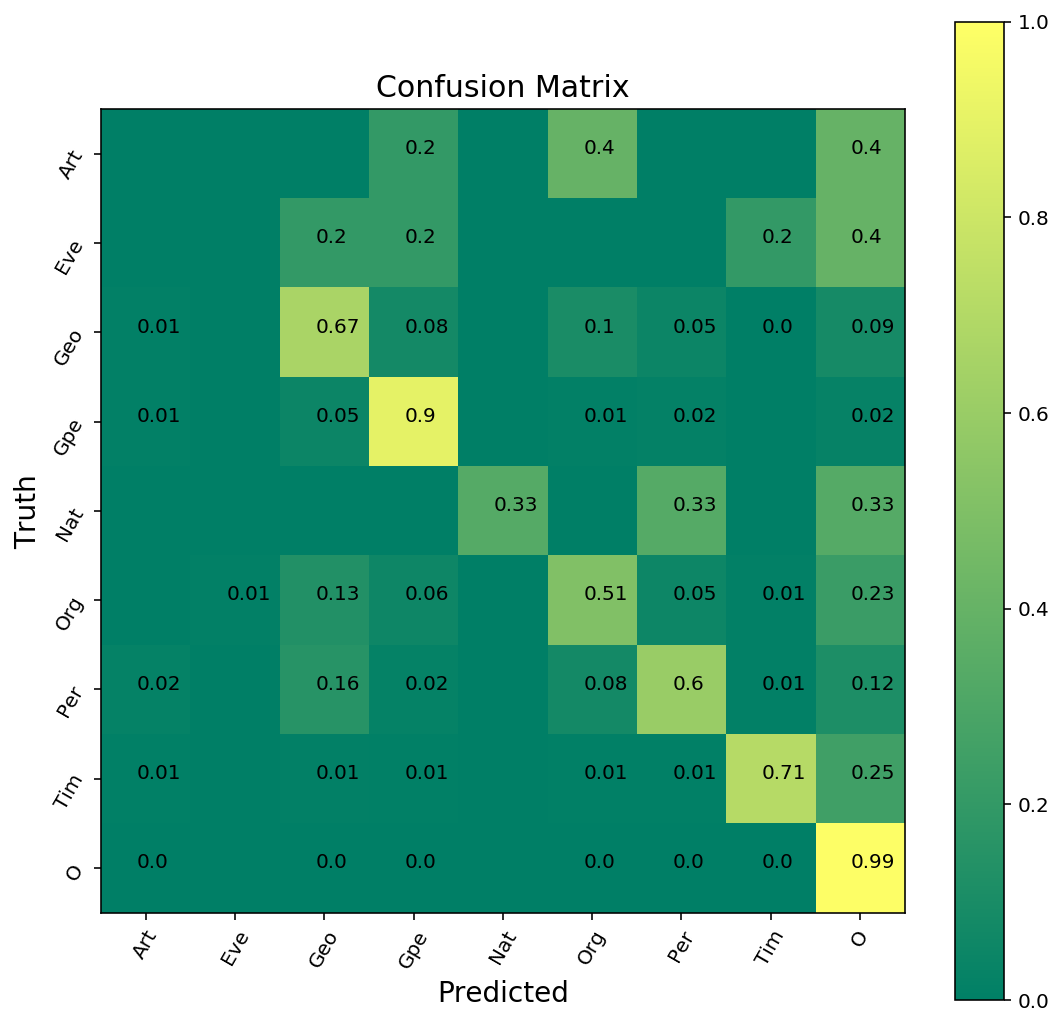

In [206]:
plot_confusion_matrix(truth=y_truth, predicted=ypred_clf, labels = labels,save_name='df_com_cm2')

### Binary-class XGBoost classifier

In [207]:
CLASSES_DICT = {'Art','Eve','Geo','Gpe','Nat','Org','Per','Tim'}
cl = []
for cl in CLASSES_DICT:
    df_current = deepcopy(df_com)
    df_current['Tag'] = df_current['Tag'].apply(lambda x: x if x  == cl else 'O')
    
    print ('Training model for class ->', cl)

    gbm_model,clf_model, tag_for_current_class = train_model(df_current[(df_current.split=='Train')|(df_current.split=='Validation')],features=xg_features)
    
    print ('Applying model for class ->', cl)
 
    pred_result = apply_model(xgb_model = gbm_model,cal_model = clf_model,df_test = df_current[(df_current.split=='Test')],tag_class_dict=tag_for_current_class,features=xg_features)
    
    pred_result.to_csv('./combined/pred_result_'+cl+'.csv')
    
    print ("Prediction Result saved to 'pred_result_",cl,".csv'")

Training model for class -> Tim


C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	validation_0-logloss:0.599534	validation_1-logloss:0.599663
[1]	validation_0-logloss:0.523048	validation_1-logloss:0.523252
[2]	validation_0-logloss:0.458901	validation_1-logloss:0.459224
[3]	validation_0-logloss:0.404772	validation_1-logloss:0.405242
[4]	validation_0-logloss:0.358762	validation_1-logloss:0.35933
[5]	validation_0-logloss:0.319049	validation_1-logloss:0.319686
[6]	validation_0-logloss:0.284396	validation_1-logloss:0.28523
[7]	validation_0-logloss:0.254311	validation_1-logloss:0.255338
[8]	validation_0-logloss:0.228181	validation_1-logloss:0.229325
[9]	validation_0-logloss:0.204828	validation_1-logloss:0.206048
[10]	validation_0-logloss:0.184275	validation_1-logloss:0.185641
[11]	validation_0-logloss:0.166018	validation_1-logloss:0.167465
[12]	validation_0-logloss:0.149886	validation_1-logloss:0.151465
[13]	validation_0-logloss:0.135504	validation_1-logloss:0.137189
[14]	validation_0-logloss:0.122765	validation_1-logloss:0.124523
[15]	validation_0-logloss:0.111395	va

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	validation_0-logloss:0.598383	validation_1-logloss:0.598377
[1]	validation_0-logloss:0.520772	validation_1-logloss:0.520762
[2]	validation_0-logloss:0.456054	validation_1-logloss:0.456043
[3]	validation_0-logloss:0.401346	validation_1-logloss:0.40134
[4]	validation_0-logloss:0.354623	validation_1-logloss:0.354624
[5]	validation_0-logloss:0.31437	validation_1-logloss:0.314374
[6]	validation_0-logloss:0.279468	validation_1-logloss:0.279487
[7]	validation_0-logloss:0.249041	validation_1-logloss:0.249084
[8]	validation_0-logloss:0.222402	validation_1-logloss:0.222454
[9]	validation_0-logloss:0.19894	validation_1-logloss:0.198999
[10]	validation_0-logloss:0.178236	validation_1-logloss:0.178309
[11]	validation_0-logloss:0.1599	validation_1-logloss:0.159983
[12]	validation_0-logloss:0.143638	validation_1-logloss:0.143745
[13]	validation_0-logloss:0.129183	validation_1-logloss:0.129303
[14]	validation_0-logloss:0.116285	validation_1-logloss:0.116417
[15]	validation_0-logloss:0.104793	valid

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	validation_0-logloss:0.598623	validation_1-logloss:0.598744
[1]	validation_0-logloss:0.521216	validation_1-logloss:0.521453
[2]	validation_0-logloss:0.457	validation_1-logloss:0.457277
[3]	validation_0-logloss:0.402385	validation_1-logloss:0.402761
[4]	validation_0-logloss:0.355724	validation_1-logloss:0.356202
[5]	validation_0-logloss:0.315534	validation_1-logloss:0.316123
[6]	validation_0-logloss:0.280861	validation_1-logloss:0.281558
[7]	validation_0-logloss:0.250491	validation_1-logloss:0.2513
[8]	validation_0-logloss:0.223908	validation_1-logloss:0.224835
[9]	validation_0-logloss:0.200432	validation_1-logloss:0.201414
[10]	validation_0-logloss:0.179767	validation_1-logloss:0.180906
[11]	validation_0-logloss:0.161411	validation_1-logloss:0.162635
[12]	validation_0-logloss:0.145188	validation_1-logloss:0.146538
[13]	validation_0-logloss:0.130769	validation_1-logloss:0.13223
[14]	validation_0-logloss:0.117854	validation_1-logloss:0.119351
[15]	validation_0-logloss:0.106312	valida

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	validation_0-logloss:0.598377	validation_1-logloss:0.598408
[1]	validation_0-logloss:0.520765	validation_1-logloss:0.520826
[2]	validation_0-logloss:0.45605	validation_1-logloss:0.456139
[3]	validation_0-logloss:0.401342	validation_1-logloss:0.401458
[4]	validation_0-logloss:0.354617	validation_1-logloss:0.354761
[5]	validation_0-logloss:0.314374	validation_1-logloss:0.314543
[6]	validation_0-logloss:0.279446	validation_1-logloss:0.279661
[7]	validation_0-logloss:0.249009	validation_1-logloss:0.249275
[8]	validation_0-logloss:0.222331	validation_1-logloss:0.22265
[9]	validation_0-logloss:0.198852	validation_1-logloss:0.199193
[10]	validation_0-logloss:0.178148	validation_1-logloss:0.178513
[11]	validation_0-logloss:0.159819	validation_1-logloss:0.160204
[12]	validation_0-logloss:0.143536	validation_1-logloss:0.143959
[13]	validation_0-logloss:0.129055	validation_1-logloss:0.129521
[14]	validation_0-logloss:0.116148	validation_1-logloss:0.116653
[15]	validation_0-logloss:0.104649	va

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	validation_0-logloss:0.598351	validation_1-logloss:0.598314
[1]	validation_0-logloss:0.520696	validation_1-logloss:0.520625
[2]	validation_0-logloss:0.455943	validation_1-logloss:0.45584
[3]	validation_0-logloss:0.401216	validation_1-logloss:0.401084
[4]	validation_0-logloss:0.354463	validation_1-logloss:0.354304
[5]	validation_0-logloss:0.314199	validation_1-logloss:0.314013
[6]	validation_0-logloss:0.279282	validation_1-logloss:0.27907
[7]	validation_0-logloss:0.248825	validation_1-logloss:0.248589
[8]	validation_0-logloss:0.222155	validation_1-logloss:0.221896
[9]	validation_0-logloss:0.198676	validation_1-logloss:0.198419
[10]	validation_0-logloss:0.177976	validation_1-logloss:0.177695
[11]	validation_0-logloss:0.159634	validation_1-logloss:0.159359
[12]	validation_0-logloss:0.143341	validation_1-logloss:0.143082
[13]	validation_0-logloss:0.128867	validation_1-logloss:0.128604
[14]	validation_0-logloss:0.115944	validation_1-logloss:0.1157
[15]	validation_0-logloss:0.104423	vali

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	validation_0-logloss:0.599799	validation_1-logloss:0.59995
[1]	validation_0-logloss:0.523302	validation_1-logloss:0.523489
[2]	validation_0-logloss:0.459444	validation_1-logloss:0.459789
[3]	validation_0-logloss:0.405589	validation_1-logloss:0.40606
[4]	validation_0-logloss:0.359585	validation_1-logloss:0.360149
[5]	validation_0-logloss:0.319957	validation_1-logloss:0.320646
[6]	validation_0-logloss:0.285645	validation_1-logloss:0.286504
[7]	validation_0-logloss:0.255901	validation_1-logloss:0.256941
[8]	validation_0-logloss:0.229862	validation_1-logloss:0.231064
[9]	validation_0-logloss:0.206679	validation_1-logloss:0.207956
[10]	validation_0-logloss:0.186205	validation_1-logloss:0.187636
[11]	validation_0-logloss:0.168033	validation_1-logloss:0.169649
[12]	validation_0-logloss:0.151972	validation_1-logloss:0.153721
[13]	validation_0-logloss:0.137702	validation_1-logloss:0.139608
[14]	validation_0-logloss:0.124947	validation_1-logloss:0.127037
[15]	validation_0-logloss:0.1134	vali

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	validation_0-logloss:0.600121	validation_1-logloss:0.600161
[1]	validation_0-logloss:0.524025	validation_1-logloss:0.524236
[2]	validation_0-logloss:0.460295	validation_1-logloss:0.460522
[3]	validation_0-logloss:0.406664	validation_1-logloss:0.406845
[4]	validation_0-logloss:0.360824	validation_1-logloss:0.361034
[5]	validation_0-logloss:0.321376	validation_1-logloss:0.321699
[6]	validation_0-logloss:0.287214	validation_1-logloss:0.287653
[7]	validation_0-logloss:0.257678	validation_1-logloss:0.258268
[8]	validation_0-logloss:0.231852	validation_1-logloss:0.232508
[9]	validation_0-logloss:0.208783	validation_1-logloss:0.209406
[10]	validation_0-logloss:0.188512	validation_1-logloss:0.189202
[11]	validation_0-logloss:0.170589	validation_1-logloss:0.171381
[12]	validation_0-logloss:0.154693	validation_1-logloss:0.1556
[13]	validation_0-logloss:0.140436	validation_1-logloss:0.141366
[14]	validation_0-logloss:0.127884	validation_1-logloss:0.128877
[15]	validation_0-logloss:0.1167	vali

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	validation_0-logloss:0.598991	validation_1-logloss:0.599114
[1]	validation_0-logloss:0.521841	validation_1-logloss:0.522138
[2]	validation_0-logloss:0.457504	validation_1-logloss:0.457962
[3]	validation_0-logloss:0.403187	validation_1-logloss:0.403791
[4]	validation_0-logloss:0.356745	validation_1-logloss:0.357469
[5]	validation_0-logloss:0.316756	validation_1-logloss:0.317616
[6]	validation_0-logloss:0.282063	validation_1-logloss:0.283098
[7]	validation_0-logloss:0.251967	validation_1-logloss:0.253089
[8]	validation_0-logloss:0.225556	validation_1-logloss:0.226758
[9]	validation_0-logloss:0.202119	validation_1-logloss:0.203503
[10]	validation_0-logloss:0.181436	validation_1-logloss:0.182968
[11]	validation_0-logloss:0.163143	validation_1-logloss:0.164785
[12]	validation_0-logloss:0.146785	validation_1-logloss:0.148595
[13]	validation_0-logloss:0.132231	validation_1-logloss:0.134238
[14]	validation_0-logloss:0.119362	validation_1-logloss:0.121531
[15]	validation_0-logloss:0.10783	v